**No warnings**

In [1]:
!pip install shutup

In [2]:
import shutup; shutup.please()

**Kaggle API token for Google Colab**

**The following steps are only for running notebook in Google Colab Environment**

In [3]:
#!pip install kaggle

In [4]:
#!mkdir ~/.kaggle
#!cp /content/kaggle.json ~/.kaggle/kaggle.json
#!chmod 600 /root/.kaggle/kaggle.json

In [5]:
#!kaggle competitions download nlp-getting-started

In [6]:
#!unzip *.zip

# Importing Required Libraries

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid", {"grid.color": ".6", "grid.linestyle": ":"})


import os
import tensorflow as tf

**Loading the dataset**

*Training dataframe*

In [8]:
#train_df = pd.read_csv("train.csv")   .... Use this command for Colab
train_df = pd.read_csv(r'../input/nlp-getting-started/train.csv')

In [9]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


5 Columns(variables) and at first look the "keyword" and "location" variables seem to house NaN(missing values).

In [10]:
print("The number of observations in Training Dataset is :",len(train_df))

The number of observations in Training Dataset is : 7613


*Testing dataframe*

In [11]:
#test_df = pd.read_csv("test.csv") .....Use this command for Colab
test_df = pd.read_csv(r'../input/nlp-getting-started/test.csv')

In [12]:
test_df.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [13]:
print("The number of observations in Testing Dataset is :",len(test_df))

The number of observations in Testing Dataset is : 3263


# Exploratory Data Analysis

Exploring into the data to investiagte the missing values and duplicates.

In [14]:
train_df.isna().sum()

id             0
keyword       61
location    2533
text           0
target         0
dtype: int64

As we can see the Training dataframe has 61 missing values "keyword" variable and 2533 missing values in the "location" variable.

In [15]:
test_df.isna().sum()

id             0
keyword       26
location    1105
text           0
dtype: int64

As we can see the Testing dataframe has 26 missing values "keyword" variable and 1105 missing values in the "location" variable.

We can make use of the **Missingno** python library to help visualise missing values in a pandas dataframe. 

It helps for quick visual summary of the completeness/incompleteness of the dataset

In [16]:
!pip install missingno

In [17]:
import missingno as msno

**Plotting a Bar Chart of the missing values**

<AxesSubplot:>

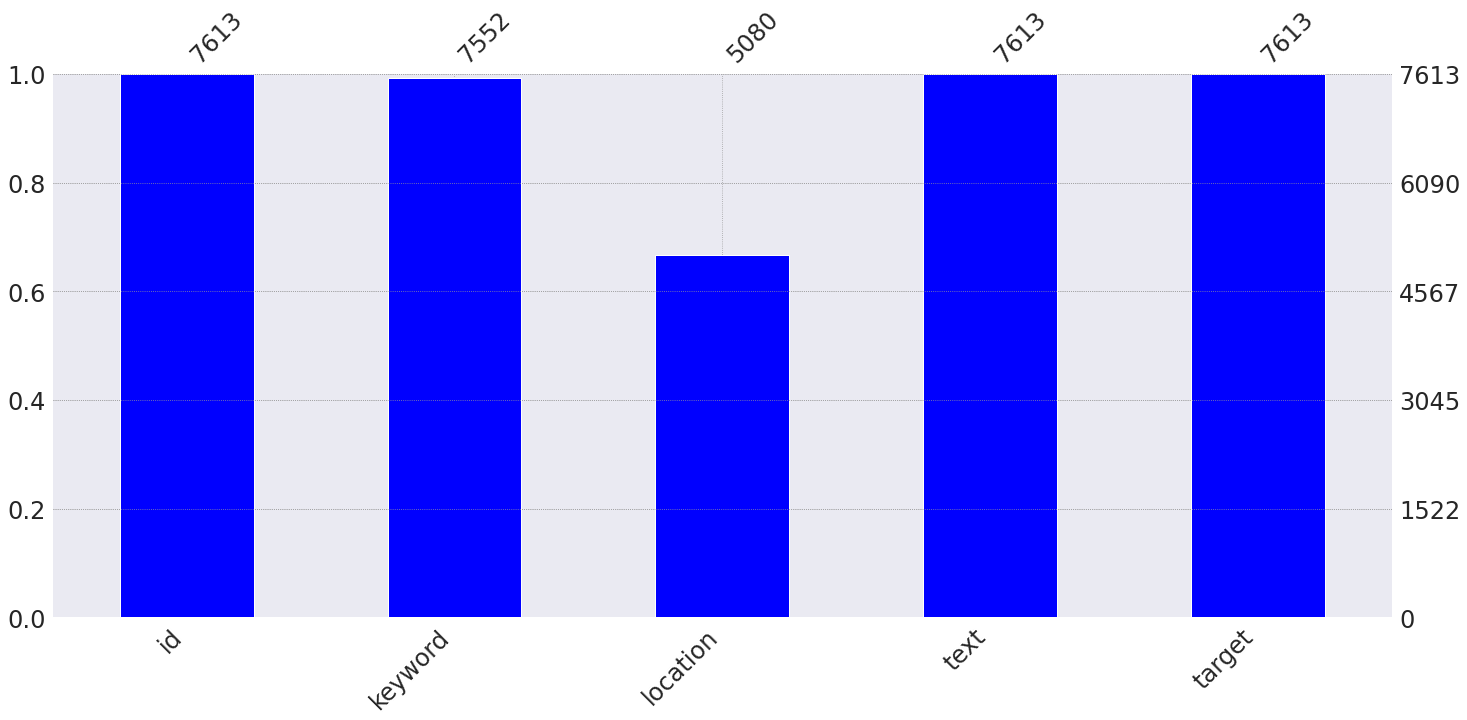

In [18]:
msno.bar(train_df,fontsize = 24, color = 'blue')

<AxesSubplot:>

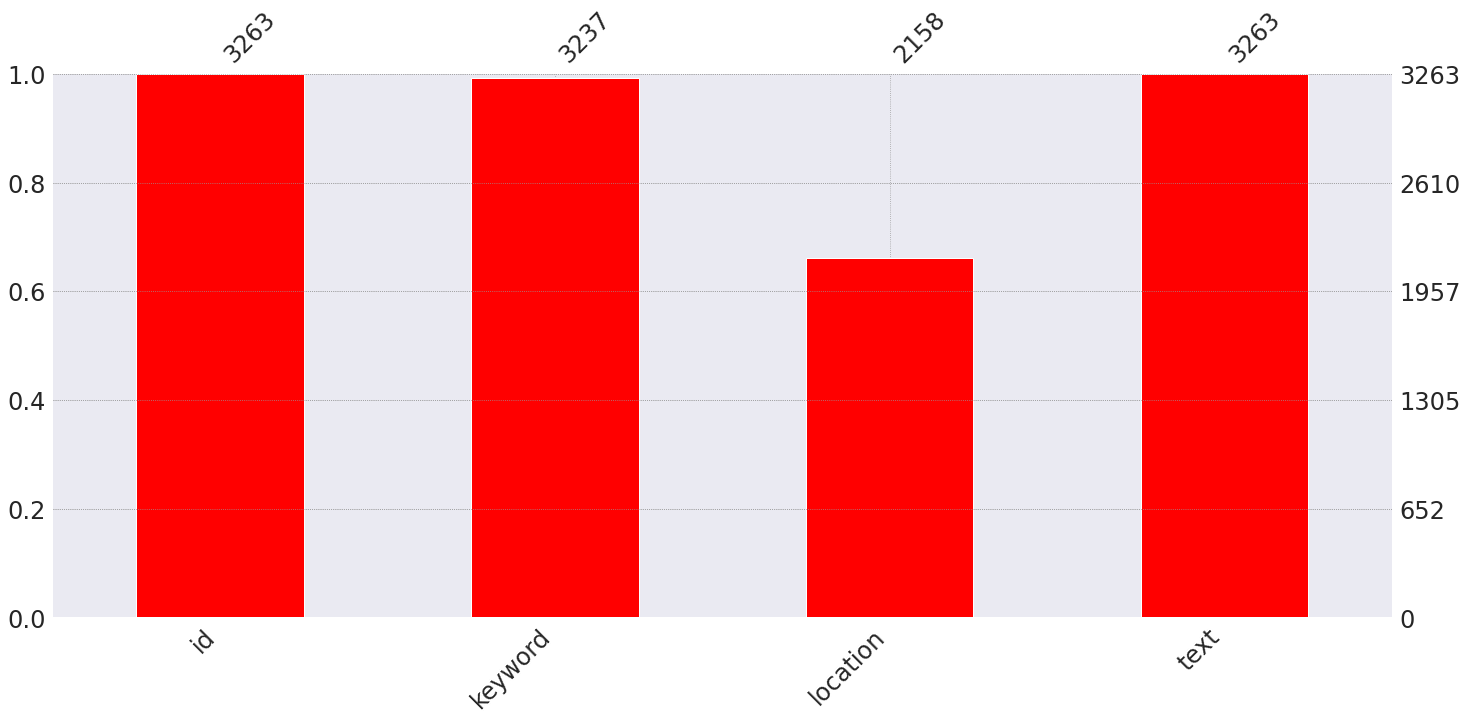

In [19]:
msno.bar(test_df,fontsize = 24, color = 'red')

**Heatmap of Missing Values**

<AxesSubplot:>

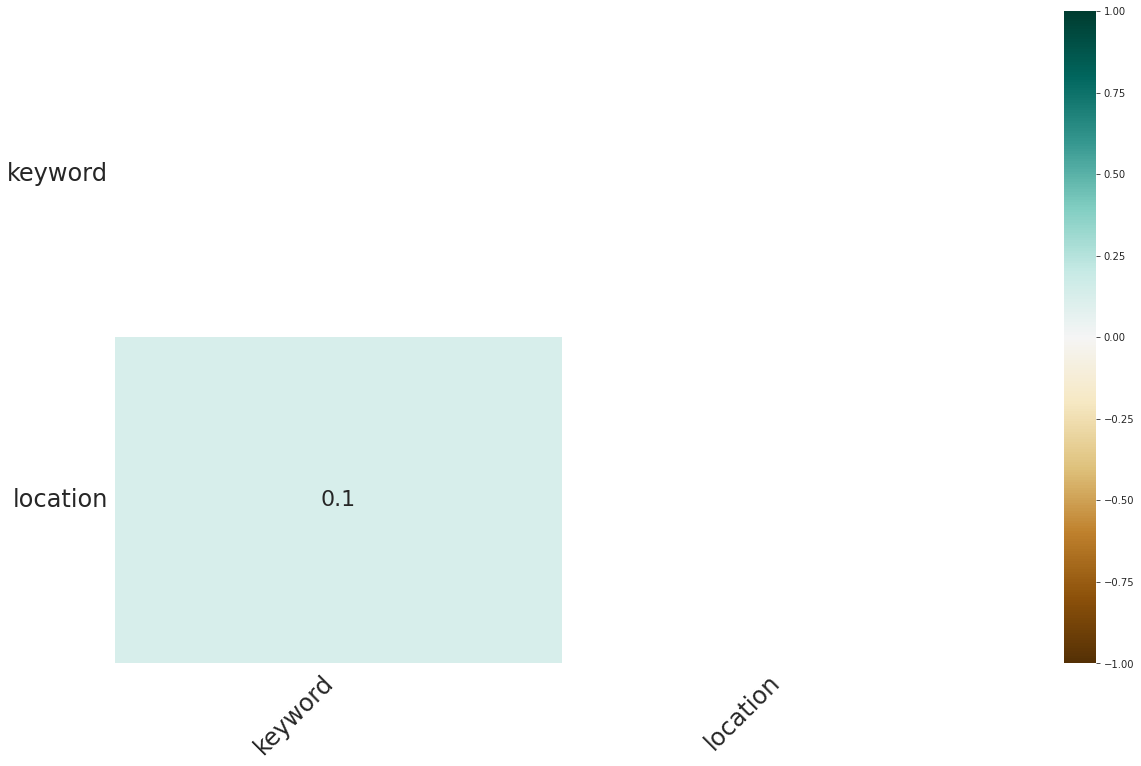

In [20]:
msno.heatmap(train_df,fontsize = 24, cmap = 'BrBG')

<AxesSubplot:>

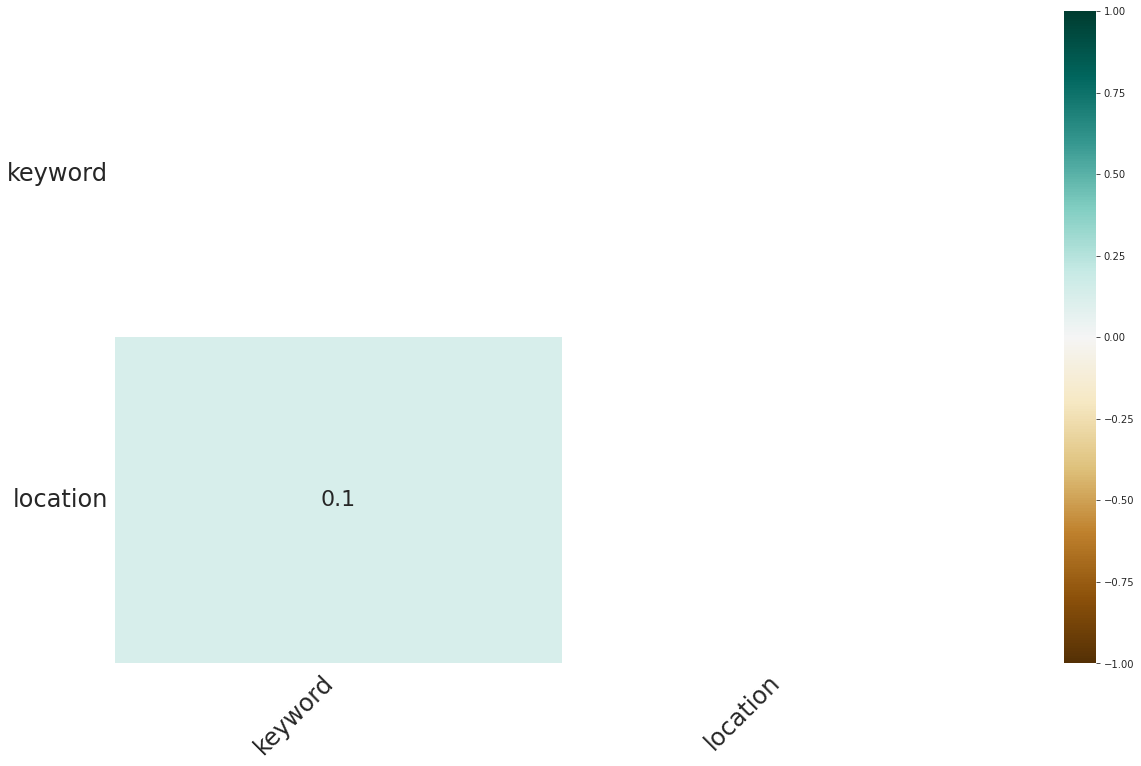

In [21]:
msno.heatmap(test_df,fontsize = 24, cmap = 'BrBG')

As it is evident that **location** is the variable with the highest missing values. There as also some missing values in the **keyword** variable.

**Investigating for Duplicates**

For both the dataframes the attempt to check duplicates will be made across text column

In [22]:
dups_text_train = train_df.pivot_table(columns=['text'], aggfunc='size')
print (dups_text_train)

text
! Residents Return To Destroyed Homes As Washington Wildfire Burns on http://t.co/UcI8stQUg1                                                   1
# handbags Genuine Mulberry Antony Cross Body Messenger Bag Dark Oak Soft Buffalo Leather:  å£279.00End Date: W... http://t.co/FTM4RKl8mN      1
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/9Naw3QOQOL                                                1
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/aOd2ftBMGU                                                1
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/eaTFro3d5x                                                1
                                                                                                                                              ..
Û÷We Can HelpÛª Says Denver Firefighter Working To Curb First Responder Suicide http://t.co/WtaFaepuKZ                     

In [23]:
print("The duplicates in the Text variable in training set :",len(dups_text_train))

The duplicates in the Text variable in training set : 7503


In [24]:
dups_text_test = test_df.pivot_table(columns=['text'], aggfunc='size')
print (dups_text_test)

text
! Sex-themed e-books given curfew in Germany on http://t.co/7NLEnCph8X                                                                            1
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/QDwRjmmk89                                                   1
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/r0FLXJx5vX                                                   1
#360WiseNews : China's Stock Market Crash: Are There Gems In The Rubble? http://t.co/vTJ1EoslrU                                                   1
#3682 Nikon D50 6.1 MP Digital SLR Camera Body 2 batteries carry bag and charger http://t.co/TeT9q0kXvl\n\n$200.00\nÛ_ http://t.co/h3XgoxTFfi    1
                                                                                                                                                 ..
ÛÏEven in the midst of devastation something within us always points the way to freedom.Û               

In [25]:
print("The duplicates in the Text variable in testing set :",len(dups_text_test))

The duplicates in the Text variable in testing set : 3243


At some places the duplicate data has a different target value from other data.

**Analysing Tweet Length**

Creating a variable named **length** in both the dataframes.

Using simple lambda function to do count the length.

In [26]:
train_df["length"] = train_df["text"].apply(lambda x:len(x))
train_df.head()

,id,keyword,location,text,target,length
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,69
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,38
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,133
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,65
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88


In [27]:
max_train = train_df['length'].max()
print("Maximum length of tweet in training set :",max_train)

Maximum length of tweet in training set : 157


In [28]:
test_df["length"] = test_df["text"].apply(lambda x:len(x))
test_df.head()

,id,keyword,location,text,length
0,0,NaN,NaN,Just happened a terrible car crash,34
1,2,NaN,NaN,"Heard about #earthquake is different cities, s...",64
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are...",96
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires,40
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan,45


In [29]:
max_test = test_df['length'].max()
print("Maximum length of tweet in testing set :",max_test)

Maximum length of tweet in testing set : 151


As we can see the longest tweet in training dataframe has a length of 157 and that in testing dataframe has a length of 151.

**Descriptive Statistics**

In [30]:
train_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,7613.0,5441.934848,3137.116090,1.0,2734.0,5408.0,8146.0,10873.0
target,7613.0,0.429660,0.495060,0.0,0.0,0.0,1.0,1.0
length,7613.0,101.037436,33.781325,7.0,78.0,107.0,133.0,157.0


<AxesSubplot:title={'center':'Descriptive Stats of Training Dataframe'}>

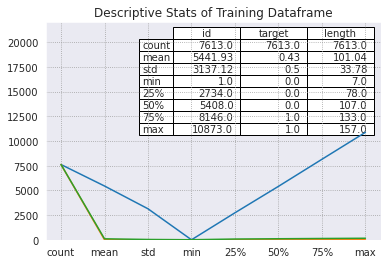

<Figure size 2000x2000 with 0 Axes>

In [31]:
from pandas.plotting import table
from matplotlib.pyplot import figure
fig,ax = plt.subplots(1,1)
ax.set_ylim([0,22000])
plt.title("Descriptive Stats of Training Dataframe")
figure(figsize = (20,20),dpi = 100)
table(ax,np.round(train_df.describe(),2),loc = "upper right",colWidths = [0.2,0.2,0.2])
train_df.describe().plot(ax=ax,legend = None)

In [32]:
test_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id,3263.0,5427.152927,3146.427221,0.0,2683.0,5500.0,8176.0,10875.0
length,3263.0,102.108183,33.972158,5.0,78.0,109.0,134.0,151.0


<AxesSubplot:title={'center':'Descriptive Stats of Testing Dataframe'}>

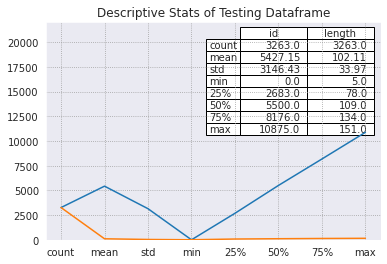

<Figure size 2000x2000 with 0 Axes>

In [33]:
fig,ax = plt.subplots(1,1)
ax.set_ylim([0,22000])
plt.title("Descriptive Stats of Testing Dataframe")
figure(figsize = (20,20),dpi = 100)
table(ax,np.round(test_df.describe(),2),loc = "upper right",colWidths = [0.2,0.2,0.2])
test_df.describe().plot(ax=ax,legend = None)

**Checking the Target Variable**

Bar Chart for counts of Target variable in Training dataframe

<AxesSubplot:xlabel='target', ylabel='count'>

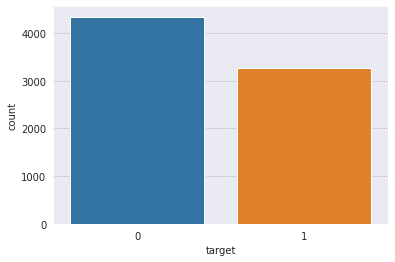

In [34]:
sns.countplot(x = 'target',data = train_df)

Pie Distribution for Target Variable

<AxesSubplot:title={'center':'Target Distribution Pie Chart'}, ylabel='target'>

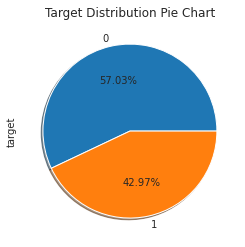

In [35]:
plt.title("Target Distribution Pie Chart")
train_df["target"].value_counts().plot(kind="pie",autopct='%.2f%%',
    shadow=True)

**Checking the distribution of the tweet length**

Text(0.5, 1.0, 'Distribution of Tweet Length')

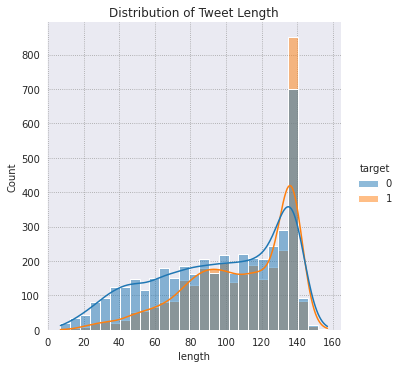

In [36]:
sns.displot(train_df,x = "length",kde = True,hue = "target")
plt.title("Distribution of Tweet Length")


As we can see from the above distribution the most length of tweets lies between the range of 130 - 140 characters.

Displaying the top 3 tweets according to the Length 

In [37]:
for tweet in train_df.sort_values(by="length", ascending=False)["text"][:3]:
    print(f"Tweet: \n{tweet}\n")

Tweet: 
when you're taking a shower and someone flushes the toilet and you have .1 second to GTFO or you get burned??????????????????????????????????????????????????

Tweet: 
It's was about 2:30 in the morning&amp;I went downstairs to watch some telly&amp;I accidentally made a loud bang&amp;my dad(who has a broken leg)walked-

Tweet: 
@CAgov If 90BLKs&amp;8WHTs colluded 2 take WHT F @USAgov AUTH Hostage&amp;2 make her look BLK w/Bioterrorism&amp;use her lgl/org IDis ID still hers?@VP



**Checking for Unique Keywords**

In [38]:
print("The number of unique keywords in our training data :",train_df['keyword'].nunique())

The number of unique keywords in our training data : 221


Plotting the top 10 keywords

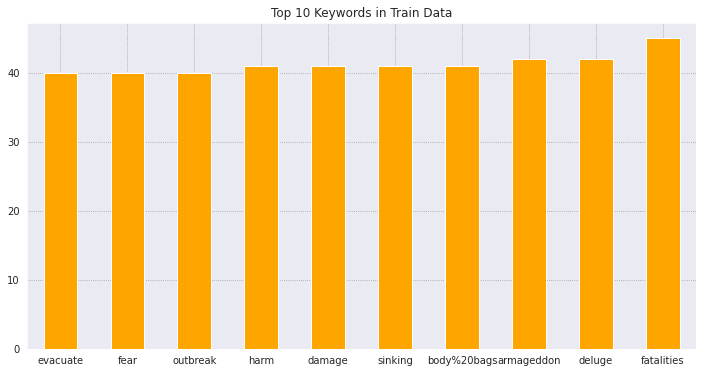

In [39]:
plt.figure(figsize=(12,6))
plt.title("Top 10 Keywords in Train Data")
train_df["keyword"].value_counts(ascending=True)[-10:].plot.bar(color = 'orange',rot = 0)
plt.show()

**Checking the top Location Tags**

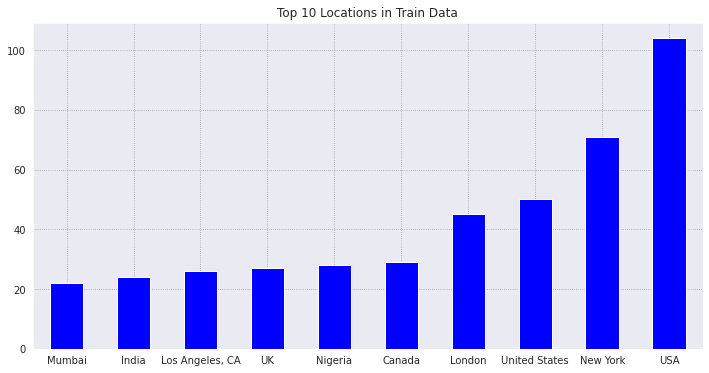

In [40]:
plt.figure(figsize=(12,6))
plt.title("Top 10 Locations in Train Data")
train_df["location"].value_counts(ascending=True)[-10:].plot.bar(color = 'blue',rot = 0)
plt.show()


*   The locations are not proper, some are countries, some are states and some are cities.
*   Most tweets are sent form the USA
*   Presence of 3341 unique locations in our data



**Presence of Special Characters**

Identifying the Special Characters in tweets using a simple lambda function comprising of Regular expressions

In [41]:
import re

In [42]:
train_df["spec_char"] = train_df["text"].map(lambda x: len(re.findall(r"[\W_]", re.sub(r"\s", "", x))))

Defining a bins using the unique count for special charcters

In [43]:
bins = train_df["spec_char"].nunique()

Text(0.5, 1.0, 'Distribution for Special Characters in Tweets')

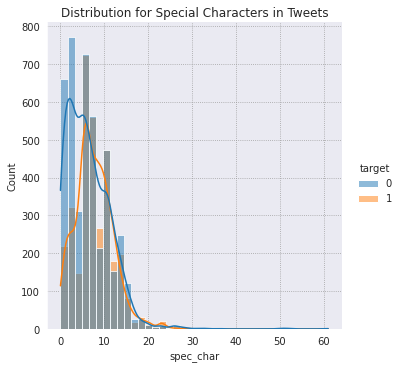

In [44]:
sns.displot(data = train_df,x = "spec_char",kde = True,hue = "target",bins = bins)
plt.title("Distribution for Special Characters in Tweets")

The distribution above shows us the most of tweets have les  than 20 special characters.

In [45]:
print("Minimum special characters in a tweet :",train_df['spec_char'].min())
print("Maximum special characters in a tweet :",train_df['spec_char'].max())

Minimum special characters in a tweet : 0
Maximum special characters in a tweet : 61


So we can observe either a tweet can have no special character or atmost 61 special charcters in it!

**Tweet word counts**

Note - This does not include the ones with special characters in them.

In [46]:
train_df["word_count"] = train_df["text"].apply(lambda x: len(re.sub(r"[\W_]", " ", x).split()))

In [47]:
print("Minimum Words in a tweet :",train_df['word_count'].min())
print("Maximum Words in a tweet :",train_df['word_count'].max())

Minimum Words in a tweet : 1
Maximum Words in a tweet : 34


We can see that the least number of words in a tweet is 1 and highest is 34.

Defining bins using the unique word count

In [48]:
bins = train_df["word_count"].nunique()

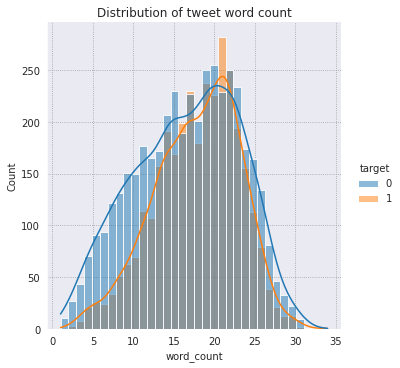

In [49]:
sns.displot(data=train_df, x="word_count", kde=True, hue="target", bins=bins)
plt.title("Distribution of tweet word count")
plt.show()

We can observe from the above distribution that tweets in general have a word count between the range of 15 - 25.

**Inferences from EDA**



*   Tweets have no standard format.
*   There are many symbols in tweets.
*   There are several special characters in tweets.
*   There are certain abbreviations.
*   Tweets also contain HTML links.
*   Tweets are duplicates, the only difference is accounts are different.
*   Some tweets have URLs.
*   Tweets show presence of URLs.



**To deal with the aforementioned problems we move to data cleaning**

# Data Cleaning

A step that is a precursor to Modelling.

Examples of all the techniques employed in the above function.

**Deleting Duplicates**

Earlier it was pointed out that that in duplicate tweets some of them had different target values. 

Deleting the duplicate data because the first data seems to have the right value

In [50]:
print("Number of observations in our training data before dropping duplicates :",train_df.shape[0])

Number of observations in our training data before dropping duplicates : 7613


In [51]:
train_df = train_df.drop_duplicates(subset="text", keep="first").reset_index(drop=True)

In [52]:
print("Number of observations in our training data after dropping duplicates :",train_df.shape[0])

Number of observations in our training data after dropping duplicates : 7503


**Lowercase conversion**

This ensures uniform format

*Note - We will be using the example of Tweet with id 222 throughout*

In [53]:
tweet = train_df.loc[train_df["id"]==222, "text"].values[0]
print(f"Before:\n{tweet}\n")

tweet = tweet.lower()
print(f"After:\n{tweet}")

Before:
Pilot Dies In Plane Crash At Car Festival https://t.co/kQ9aE6AP2B via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest

After:
pilot dies in plane crash at car festival https://t.co/kq9ae6ap2b via @youtube #crash #aircraft #airplane #pilot #death #accident #carfest


**Getting rid of Mentions**

In [54]:
print(f"Before:\n{tweet}\n")
tweet = re.sub(r"@\S+", " ", tweet)
print(f"After:\n{tweet}")

Before:
pilot dies in plane crash at car festival https://t.co/kq9ae6ap2b via @youtube #crash #aircraft #airplane #pilot #death #accident #carfest

After:
pilot dies in plane crash at car festival https://t.co/kq9ae6ap2b via   #crash #aircraft #airplane #pilot #death #accident #carfest


**Removing URLs**

In [55]:
tweet = train_df.loc[train_df["id"]==222, "text"].values[0]
print(f"Before:\n{tweet}\n")

tweet = re.sub(r"https?://\S+|www\.\S+", " ", tweet)
print(f"After:\n{tweet}")

Before:
Pilot Dies In Plane Crash At Car Festival https://t.co/kQ9aE6AP2B via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest

After:
Pilot Dies In Plane Crash At Car Festival   via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest


**Removing HTML Tags**

In [56]:
print(f"Before:\n{tweet}\n")
tweet = re.sub(r"&.*?;|<.*?>", " ", tweet)
print(f"After:\n{tweet}")

Before:
Pilot Dies In Plane Crash At Car Festival   via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest

After:
Pilot Dies In Plane Crash At Car Festival   via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest


**Handling Abbreviations**

Presence of abbreviations was detected hence we need to convert them into full words.

The reference to the next step has been the following notebook- 

Thanks to https://www.kaggle.com/rftexas/text-only-kfold-bert

In [57]:
abbreviations = {
    "$" : " dollar ",
    "€" : " euro ",
    "4ao" : "for adults only",
    "a.m" : "before midday",
    "a3" : "anytime anywhere anyplace",
    "aamof" : "as a matter of fact",
    "acct" : "account",
    "adih" : "another day in hell",
    "afaic" : "as far as i am concerned",
    "afaict" : "as far as i can tell",
    "afaik" : "as far as i know",
    "afair" : "as far as i remember",
    "afk" : "away from keyboard",
    "app" : "application",
    "approx" : "approximately",
    "apps" : "applications",
    "asap" : "as soon as possible",
    "asl" : "age, sex, location",
    "atk" : "at the keyboard",
    "ave." : "avenue",
    "aymm" : "are you my mother",
    "ayor" : "at your own risk", 
    "b&b" : "bed and breakfast",
    "b+b" : "bed and breakfast",
    "b.c" : "before christ",
    "b2b" : "business to business",
    "b2c" : "business to customer",
    "b4" : "before",
    "b4n" : "bye for now",
    "b@u" : "back at you",
    "bae" : "before anyone else",
    "bak" : "back at keyboard",
    "bbbg" : "bye bye be good",
    "bbc" : "british broadcasting corporation",
    "bbias" : "be back in a second",
    "bbl" : "be back later",
    "bbs" : "be back soon",
    "be4" : "before",
    "bfn" : "bye for now",
    "blvd" : "boulevard",
    "bout" : "about",
    "brb" : "be right back",
    "bros" : "brothers",
    "brt" : "be right there",
    "bsaaw" : "big smile and a wink",
    "btw" : "by the way",
    "bwl" : "bursting with laughter",
    "c/o" : "care of",
    "cet" : "central european time",
    "cf" : "compare",
    "cia" : "central intelligence agency",
    "csl" : "can not stop laughing",
    "cu" : "see you",
    "cul8r" : "see you later",
    "cv" : "curriculum vitae",
    "cwot" : "complete waste of time",
    "cya" : "see you",
    "cyt" : "see you tomorrow",
    "dae" : "does anyone else",
    "dbmib" : "do not bother me i am busy",
    "diy" : "do it yourself",
    "dm" : "direct message",
    "dwh" : "during work hours",
    "e123" : "easy as one two three",
    "eet" : "eastern european time",
    "eg" : "example",
    "embm" : "early morning business meeting",
    "encl" : "enclosed",
    "encl." : "enclosed",
    "etc" : "and so on",
    "faq" : "frequently asked questions",
    "fawc" : "for anyone who cares",
    "fb" : "facebook",
    "fc" : "fingers crossed",
    "fig" : "figure",
    "fimh" : "forever in my heart", 
    "ft." : "feet",
    "ft" : "featuring",
    "ftl" : "for the loss",
    "ftw" : "for the win",
    "fwiw" : "for what it is worth",
    "fyi" : "for your information",
    "g9" : "genius",
    "gahoy" : "get a hold of yourself",
    "gal" : "get a life",
    "gcse" : "general certificate of secondary education",
    "gfn" : "gone for now",
    "gg" : "good game",
    "gl" : "good luck",
    "glhf" : "good luck have fun",
    "gmt" : "greenwich mean time",
    "gmta" : "great minds think alike",
    "gn" : "good night",
    "g.o.a.t" : "greatest of all time",
    "goat" : "greatest of all time",
    "goi" : "get over it",
    "gps" : "global positioning system",
    "gr8" : "great",
    "gratz" : "congratulations",
    "gyal" : "girl",
    "h&c" : "hot and cold",
    "hp" : "horsepower",
    "hr" : "hour",
    "hrh" : "his royal highness",
    "ht" : "height",
    "ibrb" : "i will be right back",
    "ic" : "i see",
    "icq" : "i seek you",
    "icymi" : "in case you missed it",
    "idc" : "i do not care",
    "idgadf" : "i do not give a damn fuck",
    "idgaf" : "i do not give a fuck",
    "idk" : "i do not know",
    "ie" : "that is",
    "i.e" : "that is",
    "ifyp" : "i feel your pain",
    "ig" : "instagram",
    "iirc" : "if i remember correctly",
    "ilu" : "i love you",
    "ily" : "i love you",
    "imho" : "in my humble opinion",
    "imo" : "in my opinion",
    "imu" : "i miss you",
    "iow" : "in other words",
    "irl" : "in real life",
    "j4f" : "just for fun",
    "jic" : "just in case",
    "jk" : "just kidding",
    "jsyk" : "just so you know",
    "l8r" : "later",
    "lb" : "pound",
    "lbs" : "pounds",
    "ldr" : "long distance relationship",
    "lmao" : "laugh my ass off",
    "lmfao" : "laugh my fucking ass off",
    "lol" : "laughing out loud",
    "ltd" : "limited",
    "ltns" : "long time no see",
    "m8" : "mate",
    "mf" : "motherfucker",
    "mfs" : "motherfuckers",
    "mfw" : "my face when",
    "mofo" : "motherfucker",
    "mph" : "miles per hour",
    "mr" : "mister",
    "mrw" : "my reaction when",
    "ms" : "miss",
    "mte" : "my thoughts exactly",
    "nagi" : "not a good idea",
    "nbc" : "national broadcasting company",
    "nbd" : "not big deal",
    "nfs" : "not for sale",
    "ngl" : "not going to lie",
    "nhs" : "national health service",
    "nrn" : "no reply necessary",
    "nsfl" : "not safe for life",
    "nsfw" : "not safe for work",
    "nth" : "nice to have",
    "nvr" : "never",
    "nyc" : "new york city",
    "oc" : "original content",
    "og" : "original",
    "ohp" : "overhead projector",
    "oic" : "oh i see",
    "omdb" : "over my dead body",
    "omg" : "oh my god",
    "omw" : "on my way",
    "p.a" : "per annum",
    "p.m" : "after midday",
    "pm" : "prime minister",
    "poc" : "people of color",
    "pov" : "point of view",
    "pp" : "pages",
    "ppl" : "people",
    "prw" : "parents are watching",
    "ps" : "postscript",
    "pt" : "point",
    "ptb" : "please text back",
    "pto" : "please turn over",
    "qpsa" : "what happens", #"que pasa",
    "ratchet" : "rude",
    "rbtl" : "read between the lines",
    "rlrt" : "real life retweet", 
    "rofl" : "rolling on the floor laughing",
    "roflol" : "rolling on the floor laughing out loud",
    "rotflmao" : "rolling on the floor laughing my ass off",
    "rt" : "retweet",
    "ruok" : "are you ok",
    "sfw" : "safe for work",
    "sk8" : "skate",
    "smh" : "shake my head",
    "sq" : "square",
    "srsly" : "seriously", 
    "ssdd" : "same stuff different day",
    "tbh" : "to be honest",
    "tbs" : "tablespooful",
    "tbsp" : "tablespooful",
    "tfw" : "that feeling when",
    "thks" : "thank you",
    "tho" : "though",
    "thx" : "thank you",
    "tia" : "thanks in advance",
    "til" : "today i learned",
    "tl;dr" : "too long i did not read",
    "tldr" : "too long i did not read",
    "tmb" : "tweet me back",
    "tntl" : "trying not to laugh",
    "ttyl" : "talk to you later",
    "u" : "you",
    "u2" : "you too",
    "u4e" : "yours for ever",
    "utc" : "coordinated universal time",
    "w/" : "with",
    "w/o" : "without",
    "w8" : "wait",
    "wassup" : "what is up",
    "wb" : "welcome back",
    "wtf" : "what the fuck",
    "wtg" : "way to go",
    "wtpa" : "where the party at",
    "wuf" : "where are you from",
    "wuzup" : "what is up",
    "wywh" : "wish you were here",
    "yd" : "yard",
    "ygtr" : "you got that right",
    "ynk" : "you never know",
    "zzz" : "sleeping bored and tired"
}

Defining a custom function to deal with abbreviations

In [58]:
from nltk.tokenize import word_tokenize


In [59]:
def convert_abbrev(word):
    return abbreviations[word.lower()] if word.lower() in abbreviations.keys() else word


In [60]:
def convert_abbrev_in_text(text):
    tokens = word_tokenize(text)
    tokens = [convert_abbrev(word) for word in tokens]
    text = ' '.join(tokens)
    return text

**Cleaning non-words**

Since classification modelling only needs letter data we remove the following - 


*   Special Characters
*   Symbols
*   Numbers

Again we will be making the use of regular expressions to do so.

In [61]:
print(f"Before:\n{tweet}\n")
tweet = re.sub(r"[^a-z]", " ", tweet)
print(f"After:\n{tweet}")

Before:
Pilot Dies In Plane Crash At Car Festival   via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest

After:
 ilot  ies  n  lane  rash  t  ar  estival   via   ou ube   rash   ircraft   irplane   ilot   eath   ccident   ar est


**Stop Word Removal**

The most commonly used words that do not specifically contribute to any insights only increase the word count.

In [62]:
import nltk
import tensorflow as tf
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
nltk.download('omw-1.4')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package omw-1.4 to /usr/share/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [63]:
tweet = train_df.loc[train_df["id"]==222, "text"].values[0]
print(f"Before:\n{tweet}\n")

tweet = " ".join(word for word in word_tokenize(tweet) if word not in stopwords.words('english'))
print(f"After:\n{tweet}")

Before:
Pilot Dies In Plane Crash At Car Festival https://t.co/kQ9aE6AP2B via @YouTube #Crash #Aircraft #Airplane #Pilot #Death #Accident #CarFest

After:
Pilot Dies In Plane Crash At Car Festival https : //t.co/kQ9aE6AP2B via @ YouTube # Crash # Aircraft # Airplane # Pilot # Death # Accident # CarFest


**Lemmatization**

We can choose between **Stemming** and **Lemmatization** 

The difference - 
Studies -> Stemming      -> Studi
Studies -> Lemmatization -> Study

Lemmatization is a more calculated form of stemming that yields better results.

In [64]:
nltk.download("wordnet")

[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [65]:
lemma = WordNetLemmatizer()
print(f"Before:\n{tweet}\n")

tweet = " ".join(lemma.lemmatize(word) for word in word_tokenize(tweet))
print(f"After:\n{tweet}")

Before:
Pilot Dies In Plane Crash At Car Festival https : //t.co/kQ9aE6AP2B via @ YouTube # Crash # Aircraft # Airplane # Pilot # Death # Accident # CarFest

After:
Pilot Dies In Plane Crash At Car Festival http : //t.co/kQ9aE6AP2B via @ YouTube # Crash # Aircraft # Airplane # Pilot # Death # Accident # CarFest


**Single Character Pruning**

In [66]:
print(f"Before:\n{tweet}\n")
tweet = re.sub(r"\b\w\b", " ", tweet)
print(f"After:\n{tweet}")

Before:
Pilot Dies In Plane Crash At Car Festival http : //t.co/kQ9aE6AP2B via @ YouTube # Crash # Aircraft # Airplane # Pilot # Death # Accident # CarFest

After:
Pilot Dies In Plane Crash At Car Festival http : // .co/kQ9aE6AP2B via @ YouTube # Crash # Aircraft # Airplane # Pilot # Death # Accident # CarFest


A function to do data cleaning will be used.

In [67]:
def data_cleanse(tweet):
    # Lower casing
    tweet = tweet.lower()
    
    # getting rid of mentions
    tweet = re.sub(r"@\S+", " ", tweet)
    
    # removing html
    tweet = re.sub(r"&.*?;|<.*?>", " ", tweet)
    
    # url removal
    tweet = re.sub(r"https?://\S+|www\.\S+", " ", tweet)
    
    # handling abbreviations
    tweet = convert_abbrev_in_text(tweet)
    
    # non word removals (special chars)
    tweet = re.sub(r"[^a-z]", " ", tweet)
    
    # Stop word removal
    tweet = " ".join(word for word in word_tokenize(tweet) if word not in stopwords.words('english'))
    
    # lemmatization
    tweet = " ".join(lemma.lemmatize(word) for word in word_tokenize(tweet))
    
    # Single char removal
    tweet = re.sub(r"\b\w\b", "", tweet).strip()
    
    return tweet

Applying the Cleaning Function to training and testing datasets

In [68]:
train_df["cleaned_text"] = train_df["text"].apply(data_cleanse)

In [69]:
test_df["cleaned_text"] = test_df["text"].apply(data_cleanse)

**Number of words after Data Cleaning**

Using regular expressions we will find the number of words after cleaning the data

In [70]:
train_df["cleaned_words"] = train_df["cleaned_text"].apply(lambda x: len(re.sub(r"[\W_]", " ", x).split()))

**Distribution of Word Count After Cleansing**

In [71]:
bins = train_df['cleaned_words'].nunique()

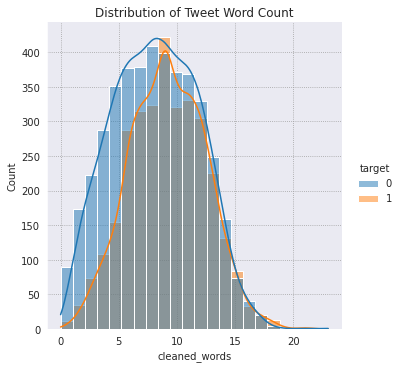

In [72]:
sns.displot(data=train_df, x="cleaned_words", kde=True, hue="target", bins=bins)
plt.title("Distribution of Tweet Word Count")
plt.show()

As there is also tweet present with 0 words.

There are 2 blank tweets so instead of deleting them we can replace them with the keywords

In [73]:
for df in [train_df, test_df]:
    df["keyword"] = df["keyword"].str.replace("%20", " ") 
    df["keyword"].fillna("", inplace=True) 
    df["cleaned_text"] = df["cleaned_text"] + " " + df["keyword"]

**Investigating the number of duplicates**

In [74]:
print("The number of duplicates in training data :",train_df['cleaned_text'].duplicated().sum())

The number of duplicates in training data : 715


In [75]:
train_df.loc[train_df["cleaned_text"].duplicated(keep=False)].sort_values("cleaned_text").head()

,id,keyword,location,text,target,length,spec_char,word_count,cleaned_text,cleaned_words
1407,2057,casualties,NaN,Afghanistan: sharp rise in women and children ...,1,101,6,17,afghanistan sharp rise woman child casualty fi...,8
1402,2049,casualties,"Afghanistan, USA",#Afghanistan: sharp rise in women and children...,1,103,8,17,afghanistan sharp rise woman child casualty fi...,8
112,163,aftershock,Belgium,Aftershock https://t.co/xMWODFMtUI,0,34,5,5,aftershock aftershock,1
128,190,aftershock,NaN,Aftershock https://t.co/jV8ppKhJY7,0,34,5,5,aftershock aftershock,1
4172,6004,hazardous,"Muntinlupa City, Philippines",@HearItFromPa Also pls help us w/ our campaign...,0,137,4,21,also pls help campaign warn public hazardous ...,12


**Dropping these duplicates**

In [76]:
print("Number of observations in training abefpre dropping duplicates : ",train_df.shape[0])

Number of observations in training abefpre dropping duplicates :  7503


In [77]:
train_df = train_df.drop_duplicates(subset="cleaned_text", keep="first").reset_index(drop=True)


In [78]:
print("Number of observations in training after dropping duplicates : ",train_df.shape[0])

Number of observations in training after dropping duplicates :  6788


**Splitting Data into Training and Validation Sets**

Training set = 90%
Validation Set = 10%

In [79]:
X = train_df["cleaned_text"]
y = train_df["target"]

In [80]:
from sklearn.model_selection import train_test_split

In [81]:
train_df

,id,keyword,location,text,target,length,spec_char,word_count,cleaned_text,cleaned_words
0,1,,NaN,Our Deeds are the Reason of this #earthquake M...,1,69,1,13,deed reason earthquake may allah forgive,6
1,4,,NaN,Forest fire near La Ronge Sask. Canada,1,38,1,7,forest fire near la ronge sask canada,7
2,5,,NaN,All residents asked to 'shelter in place' are ...,1,133,3,22,resident asked shelter place notified officer ...,11
3,6,,NaN,"13,000 people receive #wildfires evacuation or...",1,65,2,9,people receive wildfire evacuation order calif...,6
4,7,,NaN,Just got sent this photo from Ruby #Alaska as ...,1,88,2,16,got sent photo ruby alaska smoke wildfire pour...,9
...,...,...,...,...,...,...,...,...,...,...
6783,10863,,NaN,#WorldNews Fallen powerlines on G:link tram: U...,1,136,12,23,worldnews fallen powerlines link tram update ...,11
6784,10864,,NaN,on the flip side I'm at Walmart and there is a...,1,114,1,27,flip side walmart bomb everyone evacuate stay ...,9
6785,10866,,NaN,Suicide bomber kills 15 in Saudi security site...,1,121,11,19,suicide bomber kill saudi security site mosque...,13
6786,10869,,NaN,Two giant cranes holding a bridge collapse int...,1,83,5,14,two giant crane holding bridge collapse nearby...,8


In [82]:
test_df.shape

(3263, 6)

In [83]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=0)
X_test = test_df["cleaned_text"]

In [84]:
X_test.head()

0                         happened terrible car crash 
1    heard earthquake different city stay safe ever...
2    forest fire spot pond goose fleeing across str...
3                apocalypse lighting spokane wildfire 
4                  typhoon soudelor kill china taiwan 
Name: cleaned_text, dtype: object

In [85]:
X_test.shape

(3263,)

In [86]:
print("Size of Training data :",len(X_train))

Size of Training data : 6109


In [87]:
print("Size of Validation data :",len(X_val))

Size of Validation data : 679


In [88]:
print("Size of Testing data :",len(X_test))

Size of Testing data : 3263


**ML Techniques**

The thought is that if simple models are able to get a good accuracy on the training data otherwise we will move on to more advanced models.

**Naive Bayes**

In [89]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import classification_report,accuracy_score
from sklearn import metrics

In [90]:
nb = Pipeline([('vect', CountVectorizer()),
               ('tfidf', TfidfTransformer()),
               ('clf', MultinomialNB()),
              ])
nb.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [91]:
%%time
from sklearn.metrics import classification_report
y_pred_val_nb = nb.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_nb))
print("\n")
print(classification_report(y_val, y_pred_val_nb))

Accuracy on Validation set : 0.7820324005891016


              precision    recall  f1-score   support

           0       0.77      0.90      0.83       410
           1       0.80      0.60      0.69       269

    accuracy                           0.78       679
   macro avg       0.79      0.75      0.76       679
weighted avg       0.78      0.78      0.77       679

CPU times: user 19.7 ms, sys: 3.58 ms, total: 23.3 ms
Wall time: 21.1 ms


Confusion Matrix: 


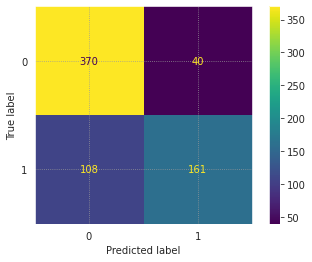

In [92]:
print('Confusion Matrix: \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_nb))

Normalized Confusion Matrix:


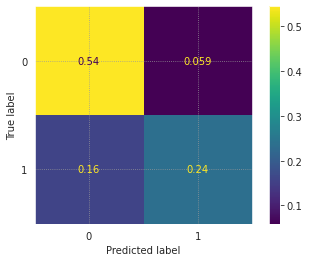

In [93]:
print('Normalized Confusion Matrix:\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_nb,normalize='all'))

**Logistic Regression**

In [94]:
from sklearn.linear_model import LogisticRegression

In [95]:
clf_lr = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(n_jobs=1, C=1e5)),
               ])
clf_lr.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LogisticRegression(C=100000.0, n_jobs=1))])

In [96]:
%%time
y_pred_val_lr = clf_lr.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_lr))
print("\n")
print(classification_report(y_val, y_pred_val_lr))

Accuracy on Validation set : 0.7407952871870398


              precision    recall  f1-score   support

           0       0.79      0.78      0.78       410
           1       0.67      0.68      0.68       269

    accuracy                           0.74       679
   macro avg       0.73      0.73      0.73       679
weighted avg       0.74      0.74      0.74       679

CPU times: user 109 ms, sys: 143 ms, total: 252 ms
Wall time: 64.1 ms


Confusion Matrix : 


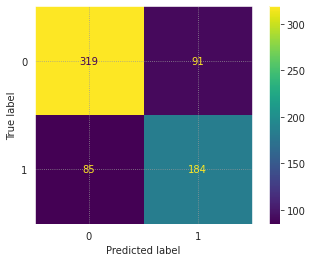

In [97]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_lr))

Normalized Confusion Matrix :


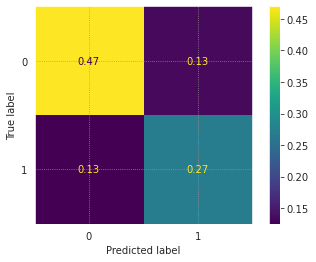

In [98]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_lr,normalize='all'))

**Support Vector Classifier**

In [99]:
from sklearn.linear_model import SGDClassifier

In [100]:
sgd = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', SGDClassifier(loss='hinge', penalty='l2',alpha=1e-3, random_state=42, max_iter=5, tol=None)),
               ])
sgd.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SGDClassifier(alpha=0.001, max_iter=5, random_state=42,
                               tol=None))])

In [101]:
%%time
y_pred_val_sgd = sgd.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_sgd))
print("\n")
print(classification_report(y_val,y_pred_val_sgd))

Accuracy on Validation set : 0.7422680412371134


              precision    recall  f1-score   support

           0       0.72      0.93      0.81       410
           1       0.82      0.45      0.58       269

    accuracy                           0.74       679
   macro avg       0.77      0.69      0.70       679
weighted avg       0.76      0.74      0.72       679

CPU times: user 99.5 ms, sys: 71.4 ms, total: 171 ms
Wall time: 44.7 ms


Confusion Matrix : 


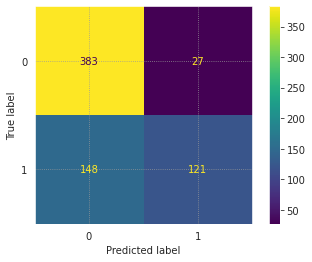

In [102]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_sgd))

Normalized Confusion Matrix :


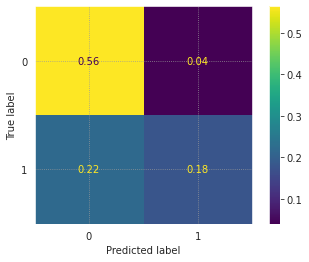

In [103]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_sgd,normalize='all'))

**Decision Tree Classifier**

In [104]:
from sklearn.tree import DecisionTreeClassifier

In [105]:
dc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=0)),
               ])
dc.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier(random_state=0))])

In [106]:
%%time
y_pred_val_dc = dc.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_dc))
print("\n")
print(classification_report(y_val, y_pred_val_dc))

Accuracy on Validation set : 0.7083946980854198


              precision    recall  f1-score   support

           0       0.75      0.77      0.76       410
           1       0.63      0.62      0.63       269

    accuracy                           0.71       679
   macro avg       0.69      0.69      0.69       679
weighted avg       0.71      0.71      0.71       679

CPU times: user 22.3 ms, sys: 819 µs, total: 23.2 ms
Wall time: 22.3 ms


Confusion Matrix : 


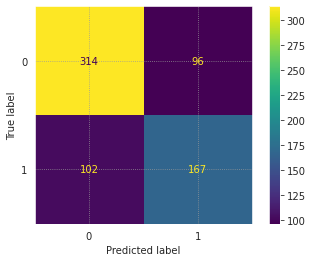

In [107]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_dc))

Normalized Confusion Matrix :


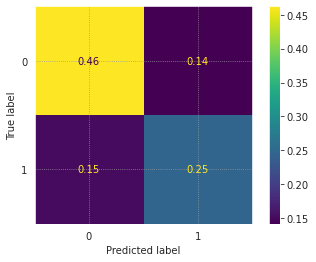

In [108]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_dc,normalize='all'))

**Random Forest Classifier**

In [109]:
from sklearn.ensemble import RandomForestClassifier

In [110]:
rf = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier(n_estimators=100, max_depth=50, min_samples_split=2, min_samples_leaf = 2))
               ])
rf.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 RandomForestClassifier(max_depth=50, min_samples_leaf=2))])

In [111]:
%%time
y_pred_val_rf = rf.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_rf))
print("\n")
print(classification_report(y_val, y_pred_val_rf))

Accuracy on Validation set : 0.7216494845360825


              precision    recall  f1-score   support

           0       0.70      0.95      0.80       410
           1       0.83      0.38      0.52       269

    accuracy                           0.72       679
   macro avg       0.76      0.66      0.66       679
weighted avg       0.75      0.72      0.69       679

CPU times: user 56.4 ms, sys: 1.32 ms, total: 57.7 ms
Wall time: 55.5 ms


Confusion Matrix : 


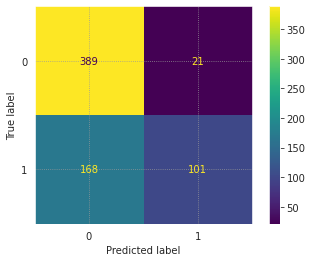

In [112]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_rf))

Normalized Confusion Matrix :


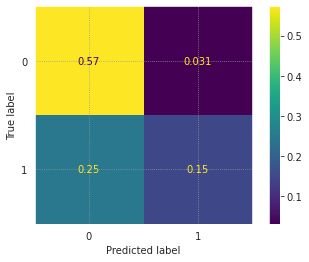

In [113]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_rf,normalize='all'))

**MLP Classifier**

In [114]:
from sklearn.neural_network import MLPClassifier

In [115]:
mlp = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', MLPClassifier(random_state=1, max_iter=300)),
               ])
mlp.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MLPClassifier(max_iter=300, random_state=1))])

In [116]:
%%time
y_pred_val_mlp = mlp.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_mlp))
print("\n")
print(classification_report(y_val, y_pred_val_mlp))

Accuracy on Validation set : 0.7290132547864506


              precision    recall  f1-score   support

           0       0.78      0.77      0.77       410
           1       0.65      0.67      0.66       269

    accuracy                           0.73       679
   macro avg       0.72      0.72      0.72       679
weighted avg       0.73      0.73      0.73       679

CPU times: user 72.3 ms, sys: 58.4 ms, total: 131 ms
Wall time: 50 ms


Confusion Matrix : 


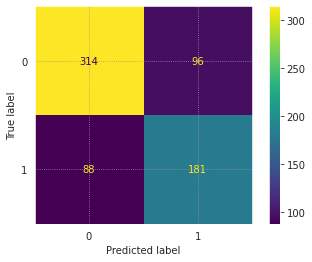

In [117]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_mlp))

Normalized Confusion Matrix :


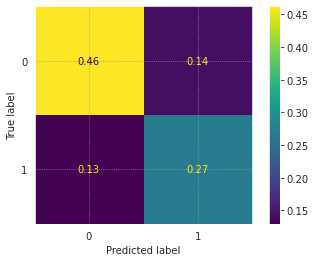

In [118]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_mlp,normalize='all'))

**Gradient Boosting Classifier**

In [119]:
from sklearn.ensemble import GradientBoostingClassifier

In [120]:
gbc = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier(n_estimators=100, learning_rate=1.0,max_depth=1, random_state=0)),
               ])
gbc.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 GradientBoostingClassifier(learning_rate=1.0, max_depth=1,
                                            random_state=0))])

In [121]:
%%time
y_pred_val_gbc = gbc.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_gbc))
print("\n")
print(classification_report(y_val, y_pred_val_gbc))

Accuracy on Validation set : 0.7584683357879234


              precision    recall  f1-score   support

           0       0.78      0.83      0.81       410
           1       0.72      0.65      0.68       269

    accuracy                           0.76       679
   macro avg       0.75      0.74      0.74       679
weighted avg       0.76      0.76      0.76       679

CPU times: user 22.9 ms, sys: 1.91 ms, total: 24.8 ms
Wall time: 24.5 ms


Confusion Matrix : 


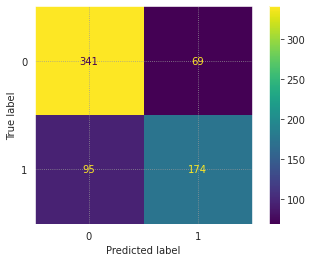

In [122]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_gbc))

Normalized Confusion Matrix :


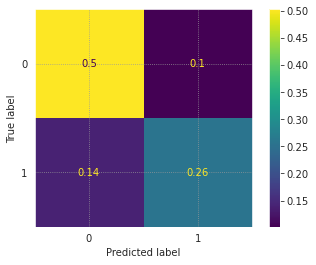

In [123]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_gbc,normalize='all'))

**Light GBM Classifier**

In [124]:
from lightgbm import LGBMClassifier

In [125]:
lgbm = Pipeline([('vect', CountVectorizer()),
                ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier()),
               ])
lgbm.fit(X_train, y_train)

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier())])

In [126]:
%%time
y_pred_val_lgbm = lgbm.predict(X_val)
print('Accuracy on Validation set :',accuracy_score(y_val, y_pred_val_lgbm))
print("\n")
print(classification_report(y_val, y_pred_val_lgbm))

Accuracy on Validation set : 0.7687776141384389


              precision    recall  f1-score   support

           0       0.77      0.89      0.82       410
           1       0.77      0.59      0.67       269

    accuracy                           0.77       679
   macro avg       0.77      0.74      0.75       679
weighted avg       0.77      0.77      0.76       679

CPU times: user 65.5 ms, sys: 839 µs, total: 66.3 ms
Wall time: 28.5 ms


Confusion Matrix : 


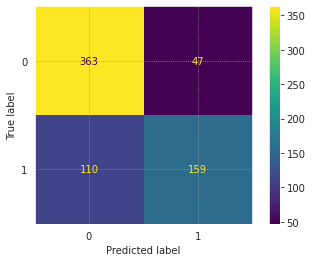

In [127]:
print('Confusion Matrix : \n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_lgbm))

Normalized Confusion Matrix :


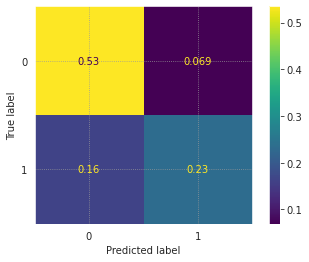

In [128]:
print('Normalized Confusion Matrix :\n',metrics.ConfusionMatrixDisplay.from_predictions(y_val, y_pred_val_lgbm,normalize='all'))

**Accuracy scores on Validation sets by Models so far**

In [129]:
print('Accuracy of Naive Bayes on Validation set :',accuracy_score(y_val, y_pred_val_nb))
print('\nAccuracy of Logistic Regression on Validation set :',accuracy_score(y_val, y_pred_val_lr))
print('\nAccuracy of Support Vector on Validation set :',accuracy_score(y_val, y_pred_val_sgd))
print('\nAccuracy of Decision Tree on Validation set :',accuracy_score(y_val, y_pred_val_dc))
print('\nAccuracy of Random Forest on Validation set :',accuracy_score(y_val, y_pred_val_rf))
print('\nAccuracy of MLP Classifier on Validation set :',accuracy_score(y_val, y_pred_val_mlp))
print('\nAccuracy of Gradient Boosting Classifier on Validation set :',accuracy_score(y_val, y_pred_val_gbc))
print('\nAccuracy Light GBM Classifier on Validation set :',accuracy_score(y_val, y_pred_val_lgbm))

Accuracy of Naive Bayes on Validation set : 0.7820324005891016

Accuracy of Logistic Regression on Validation set : 0.7407952871870398

Accuracy of Support Vector on Validation set : 0.7422680412371134

Accuracy of Decision Tree on Validation set : 0.7083946980854198

Accuracy of Random Forest on Validation set : 0.7216494845360825

Accuracy of MLP Classifier on Validation set : 0.7290132547864506

Accuracy of Gradient Boosting Classifier on Validation set : 0.7584683357879234

Accuracy Light GBM Classifier on Validation set : 0.7687776141384389


**Now testing all our ML Models on the test data to see their scores**

As our best Model is Naive Bayes we choose that for predictions.

**Code to Submit**

In [130]:
y_pred_test_nb = nb.predict(X_test)

In [131]:
preds = y_pred_test_nb.reshape(len(y_pred_test_nb))
for i in range(len(preds)):
    if preds[i]>0.9:
        preds[i] = 1
    else:
        preds[i] = 0

In [132]:
idCol = test_df['id'].to_numpy()
submission = pd.DataFrame({'id': idCol, 'target': preds})
submission.target = submission.target.astype(int)
submission.set_index('id')

,target
id,
0,1
2,0
3,1
9,1
11,1
...,...
10861,1
10865,0
10868,1


In [133]:
submission.to_csv('submission.csv',index=False)